In [1]:
## My Installs
!pip install BeautifulSoup4
!pip install lxml
!pip install geocoder
!pip install seaborn
!pip install wordcloud
!pip install sklearn --upgrade
!pip install folium --upgrade

## My Imports
import pandas as pd
from bs4 import BeautifulSoup
import requests ## Used to make requisitions
import geocoder ## Used to capture latitude e longitude from location
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import folium

import warnings
warnings.filterwarnings('ignore')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: Cryptograp

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=5ef76654eeb9aa75f2e21f28006f94b1d876d955104fe902521b585cf1fb4891
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 94 kB 7.2 MB/s  eta 0:00:01


In [14]:
# PARAMETERS - API FOURSQUARE

CLIENT_ID = 'TTBBUBTMALN1153OUWS3V2JL3BRWIMEIRZTJNETRPGK25NUG'
CLIENT_SECRET = 'H4V2F2CVGYHJVIY2AY0AHH4IFRH31YHFYFFIFZ03EXHN4H1J'
VERSION = '20180605'

# PARAMETERS - INIT FOLIUM

LOCATION_SPEC = '{}, TEXAS, DALLAS, EUA'
LATITUDE_DALLAS = 32.77815
LONGITUDE_DALLAS = -96.7954

In [3]:
## Function capture Latitude and Longitue from Neighborhood

def get_latlng (neighborhood):
  
  lat_lng_coords = None 
  while (lat_lng_coords is None): 
      g = geocoder.arcgis (LOCATION_SPEC.format (neighborhood)) 
      lat_lng_coords = g.latlng 
  return lat_lng_coords

## Function capture details venue with API Foursquare

def get_venues(lat,lng):
    
  #set variables
  radius = 3000
  LIMIT = 100
  
  #url to fetch data from foursquare api
  url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
          CLIENT_ID, 
          CLIENT_SECRET, 
          VERSION, 
          lat, 
          lng, 
          radius, 
          LIMIT)
  
  # get all the data
  results = requests.get(url).json()
  venue_data = results["response"]['groups'][0]['items']
  venue_details = []
  for row in venue_data:
      try:
          venue_id = row['venue']['id']
          venue_name = row['venue']['name']
          venue_category = row['venue']['categories'][0]['name']
          venue_origin = row['venue']['categories'][0]['shortName']
          venue_latitude = row['venue']['location']['lat']
          venue_longitude = row['venue']['location']['lng']
          venue_details.append([venue_id, venue_name, venue_category, venue_origin, venue_latitude, venue_longitude])
      except KeyError:
          pass
      
  column_names=['ID', 'Name', 'Category', 'Origin', 'Latitude', 'Longitude']
  df = pd.DataFrame(venue_details, columns = column_names)
  print("done!")
  return df

def get_info(id):

  #url to fetch data from foursquare api
  url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&v={}&client_secret={}'.format(
          id,
          CLIENT_ID, 
          VERSION, 
          CLIENT_SECRET)

  # get all the data
  result = requests.get(url).json()
  venue_info = result['response']

  return venue_info
  
def return_most_common_venues(row, num_top_venues):

  row_categories = row.iloc[1:]
  row_categories_sorted = row_categories.sort_values(ascending = False)

  return row_categories_sorted.index.values[0:num_top_venues]

In [9]:
response = requests.get('https://www.homesnacks.com/best-neighborhoods-in-dallas-tx/#:~:text=Detailed%20List%20Of%20The%20Best%20Neighborhoods%20To%20Live,%20%20%24114%2C929%20%2028%20more%20rows%20')
soup = BeautifulSoup(response.content, 'lxml')
table = soup.find_all('table')[0]
data = pd.read_html(str(table))

source_table = pd.DataFrame(data[0])
source_table

,Rank,Neighborhood,Population,Home Value,Median Income
0,1,University Park,24259,"$1,176,311","$198,578"
1,2,Highland Park,8797,"$1,383,288","$197,247"
2,3,North Dallas,40893,"$466,340","$120,158"
3,4,Bluffview,15001,"$463,807","$114,929"
4,5,Oak Lawn,50766,"$233,466","$80,066"
5,6,Far North,163453,"$215,465","$73,621"
6,7,M Streets,34572,"$246,297","$75,322"
7,8,Government District,850,"$285,200","$78,574"
8,9,Main Street District,987,"$285,200","$78,574"
9,10,Preston Hollow,83392,"$271,338","$84,470"


In [10]:
list_neighborhood = source_table['Neighborhood']
list_neighborhood

0                University Park
1                  Highland Park
2                   North Dallas
3                      Bluffview
4                       Oak Lawn
5                      Far North
6                      M Streets
7            Government District
8           Main Street District
9                 Preston Hollow
10       Farmers Market District
11          City Center District
12    West End Historic District
13              Reunion District
14              Northeast Dallas
15    Convention Center District
16                     Near East
17                     Oak Cliff
18              Winnetka Heights
19                Lake Highlands
20                 Cockrell Hill
21              Southwest Dallas
22               Five Mile Creek
23               Love Field Area
24            Urbandale-Parkdale
25              Southeast Dallas
26                    Wolf Creek
27                    Eagle Ford
28                   Cedar Crest
29      South Boulevard-Park Row
30        

In [11]:
columns_names = ['Neighborhood', 'Latitude', 'Longitude']
neighborhood_dallas = pd.DataFrame(columns = columns_names)

for row in list_neighborhood:
  Neighborhood = row
  coords = get_latlng(Neighborhood)
  neighborhood_dallas = neighborhood_dallas.append({'Neighborhood':Neighborhood, 'Latitude':coords[0], 'Longitude':coords[1]}, ignore_index = True)

neighborhood_dallas

,Neighborhood,Latitude,Longitude
0,University Park,32.845360,-96.796990
1,Highland Park,32.828480,-96.797030
2,North Dallas,32.893120,-96.793130
3,Bluffview,32.856870,-96.829240
4,Oak Lawn,32.802330,-96.803650
5,Far North,33.001127,-96.829613
6,M Streets,32.823870,-96.768420
7,Government District,29.415324,-98.445432
8,Main Street District,32.784558,-96.780280
9,Preston Hollow,32.887500,-96.863180


In [12]:
target = 'Restaurant'
columns_names = ['Neighborhood', 'ID', 'Name', 'Latitude', 'Longitude']
restaurants_dallas = pd.DataFrame(columns = columns_names)
count=1

for row in neighborhood_dallas.values.tolist():
  Neighborhood, Latitude, Longitude = row
  venues = get_venues(Latitude, Longitude)
  ##restaurants = venues[venues['Category'] == target]
  restaurants = venues[venues['Category'].str.contains(target)]
  print('(',count,'/',len(neighborhood_dallas),')', 
        target + ' in ' + 
        Neighborhood + ': ' + 
        str(len(restaurants)))
  
  for detail in restaurants.values.tolist():
    id, name, category, food, lat, lng = detail
    restaurants_dallas = restaurants_dallas.append({
        'Neighborhood':Neighborhood, 'ID':id, 'Name':name, 
        'Category':category, 'Food':food, 
        'Latitude':lat, 'Longitude':lng}, ignore_index = True)
  count += 1

done!
( 1 / 32 ) Restaurant in University Park: 35
done!
( 2 / 32 ) Restaurant in Highland Park: 35
done!
( 3 / 32 ) Restaurant in North Dallas: 34
done!
( 4 / 32 ) Restaurant in Bluffview: 29
done!
( 5 / 32 ) Restaurant in Oak Lawn: 35
done!
( 6 / 32 ) Restaurant in Far North: 33
done!
( 7 / 32 ) Restaurant in M Streets: 28
done!
( 8 / 32 ) Restaurant in Government District: 11
done!
( 9 / 32 ) Restaurant in Main Street District: 21
done!
( 10 / 32 ) Restaurant in Preston Hollow: 25
done!
( 11 / 32 ) Restaurant in Farmers Market District: 16
done!
( 12 / 32 ) Restaurant in City Center District: 4
done!
( 13 / 32 ) Restaurant in West End Historic District: 19
done!
( 14 / 32 ) Restaurant in Reunion District: 23
done!
( 15 / 32 ) Restaurant in Northeast Dallas: 33
done!
( 16 / 32 ) Restaurant in Convention Center District: 8
done!
( 17 / 32 ) Restaurant in Near East: 9
done!
( 18 / 32 ) Restaurant in Oak Cliff: 16
done!
( 19 / 32 ) Restaurant in Winnetka Heights: 17
done!
( 20 / 32 ) Re

In [13]:
restaurants_dallas = restaurants_dallas.drop_duplicates(subset=['ID']).reset_index(drop = True) ## Remove items ID duplicates and reset index
restaurants_dallas

,Neighborhood,ID,Name,Latitude,Longitude,Category,Food
0,University Park,4a58a1caf964a5209bb71fe3,Kuby's Sausage House,32.846928,-96.788036,German Restaurant,German
1,University Park,4bb7daf51261d13a3dfee798,Half Shells Oyster Bar & Grill,32.847150,-96.788017,Seafood Restaurant,Seafood
2,University Park,4ad91227f964a520c91721e3,Bandito's Tex Mex Cantina,32.847093,-96.788043,Mexican Restaurant,Mexican
3,University Park,504d3ac2e4b04dcd18729413,East Hampton Sandwich Co.,32.849739,-96.787727,New American Restaurant,New American
4,University Park,4c378fbd2c8020a1b6408900,Dive Coastal Cuisine,32.849459,-96.787456,Seafood Restaurant,Seafood
...,...,...,...,...,...,...,...
434,Northwest Dallas,4b1b2accf964a5201ef923e3,The Cheesecake Factory,32.864129,-96.773056,American Restaurant,American
435,Northwest Dallas,507c9811e4b062f7dfeb5a27,Seasons 52,32.866844,-96.773495,New American Restaurant,New American
436,Northwest Dallas,4b1592fbf964a5201baf23e3,Maggiano's Little Italy,32.866766,-96.772638,Italian Restaurant,Italian
437,Northwest Dallas,4b1d5cc3f964a520610f24e3,Panda Express,32.869477,-96.773636,Chinese Restaurant,Chinese


In [18]:
DALLAS_COORDINATES = (LATITUDE_DALLAS, LONGITUDE_DALLAS)
map_dallas = folium.Map(location = DALLAS_COORDINATES, zoom_start = 11)

locations = restaurants_dallas[['Latitude', 'Longitude']]
location_list = locations.values.tolist()

print("Number of point(s): " + str(len(location_list)))

for i in range(0, len(location_list)):

  point_name = restaurants_dallas['Name'][i]
  point_yard = restaurants_dallas['Neighborhood'][i]
  point_category = restaurants_dallas['Category'][i]
  point_detail = '<b>' + point_name + '</b><br /><i>' + point_category + ' in '  + point_yard + '</i>'
  
  label = '{}'.format(point_detail)

  if (point_category == 'Chinese Restaurant'):
    folium.Marker(
        location_list[i], 
        popup = point_detail, 
        tooltip = point_detail, 
        icon = folium.Icon(color='red')).add_to(map_dallas)
  else:
    folium.Marker(
        location_list[i], 
        popup = point_detail, 
        tooltip = point_detail).add_to(map_dallas)

folium.Circle([LATITUDE_DALLAS, LONGITUDE_DALLAS], radius = 20000).add_to(map_dallas)
display(map_dallas)

Number of point(s): 439


In [19]:
ch_restaurants_dallas = restaurants_dallas[restaurants_dallas['Category'].str.contains('Chinese Restaurant')]
ch_restaurants_dallas = ch_restaurants_dallas.drop_duplicates(subset=['ID']).reset_index(drop = True) ## Remove items ID duplicates and reset index
ch_restaurants_dallas

,Neighborhood,ID,Name,Latitude,Longitude,Category,Food
0,North Dallas,4b6cc5e9f964a52066532ce3,Royal China,32.895957,-96.802450,Chinese Restaurant,Chinese
1,North Dallas,4bcfa5afa8b3a5935cb9625f,Tam's Egg Roll,32.909499,-96.773740,Chinese Restaurant,Chinese
2,Bluffview,4b1ea0adf964a520f11c24e3,Howard Wang's China Grill,32.864757,-96.836119,Chinese Restaurant,Chinese
3,Far North,4b1b1438f964a520bdf723e3,P.F. Chang's,32.998519,-96.830235,Chinese Restaurant,Chinese
4,Far North,4ba0078ef964a520bc5337e3,Panda Express,32.987595,-96.841748,Chinese Restaurant,Chinese
5,Government District,4d03c9f62f96f04dc2f21954,WEN WAH Chinese Restaurant,29.426081,-98.461584,Chinese Restaurant,Chinese
6,Government District,514ce8c6e4b04b41066eb708,Suyen's Chinese Restaurant.,29.396156,-98.432898,Chinese Restaurant,Chinese
7,City Center District,4c77f5353badb1f7de194a54,Royal Buffet,31.807265,-94.192397,Chinese Restaurant,Chinese
8,Convention Center District,4af72bcaf964a520bb0622e3,Skillman Wok,32.857740,-97.008372,Chinese Restaurant,Chinese
9,Near East,4f35a4aae4b0d408a2838876,Wah Wah Chinese,32.759323,-96.756416,Chinese Restaurant,Chinese


In [20]:
map_dallas_ch = folium.Map(location = DALLAS_COORDINATES, zoom_start = 11)

locations = ch_restaurants_dallas[['Latitude', 'Longitude']]
location_list = locations.values.tolist()

print("Number of point(s): " + str(len(location_list)))

for j in range(0, len(location_list)):

  point_name = ch_restaurants_dallas['Name'][j]
  point_yard = ch_restaurants_dallas['Neighborhood'][j]
  point_category = ch_restaurants_dallas['Category'][j]
  point_detail = '<b>' + point_name + '</b><br /><i>' + point_category + ' in '  + point_yard + '</i>'

  folium.Marker(
      location_list[j], 
      popup = point_detail, 
      tooltip = point_detail, 
      icon = folium.Icon(color='green')).add_to(map_dallas_ch)
  
folium.Circle([LATITUDE_DALLAS, LONGITUDE_DALLAS], radius = 20000).add_to(map_dallas_ch)
display(map_dallas_ch)

Number of point(s): 20


In [21]:
restaurants_category = restaurants_dallas.groupby('Food').size().reset_index(name='Count')
restaurants_category = restaurants_category.sort_values(by='Count', ascending = False).reset_index(drop = True) ## Remove items ID duplicates and reset index
restaurants_category

,Food,Count
0,Mexican,82
1,Fast Food,82
2,American,52
3,Seafood,30
4,Italian,22
5,Chinese,20
6,Restaurant,16
7,New American,16
8,Sushi,16
9,Thai,14


In [22]:
restaurants_neighborhood = restaurants_dallas.groupby(['Neighborhood', 'Food']).size().reset_index(name='Count')
restaurants_neighborhood = restaurants_neighborhood.sort_values(by='Food', ascending = False).reset_index(drop = True)
restaurants_neighborhood

,Neighborhood,Food,Count
0,Far North,Vietnamese,1
1,M Streets,Vietnamese,1
2,South Dallas,Vietnamese,4
3,North Dallas,Vietnamese,2
4,Reunion District,Vegetarian / Vegan,1
...,...,...,...
213,Southwest Dallas,American,1
214,Reunion District,American,4
215,South Boulevard-Park Row,American,1
216,South Dallas,American,1


In [25]:
 print('There are {} unique categories.'.format(len(restaurants_dallas['Category'].unique())))
 print('There are {} restaurants total in the Dallas, TX area.'.format(len(restaurants_dallas['ID'].unique())))
 print('There are {} chinese restaurants.'.format(len(ch_restaurants_dallas['ID'].unique())))

There are 35 unique categories.
There are 439 restaurants total in the Dallas, TX area.
There are 20 chinese restaurants.


In [26]:
# one hot encoding, fancy
neighborhood_onehot = pd.get_dummies(restaurants_dallas[['Food']], prefix="", prefix_sep="")
neighborhood_onehot['Neighborhood'] = restaurants_dallas['Neighborhood']
fixed_columns = [neighborhood_onehot.columns[-1]] + list(neighborhood_onehot.columns[:-1])
neighborhood_onehot = neighborhood_onehot[fixed_columns]


neighborhood_grouped = neighborhood_onehot.groupby('Neighborhood').mean().reset_index()
neighborhood_grouped

,Neighborhood,American,Asian,Brazilian,Cajun / Creole,Caribbean,Chinese,Comfort Food,Fast Food,French,...,Salvadoran,Seafood,South American,Southern / Soul,Sushi,Tapas,Tex-Mex,Thai,Vegetarian / Vegan,Vietnamese
0,Bluffview,0.142857,0.000000,0.000000,0.0000,0.000000,0.071429,0.000000,0.214286,0.071429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Cedar Crest,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,City Center District,0.000000,0.000000,0.000000,0.0000,0.000000,0.250000,0.000000,0.750000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Cockrell Hill,0.000000,0.000000,0.000000,0.0000,0.000000,0.125000,0.000000,0.750000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000
4,Convention Center District,0.250000,0.000000,0.000000,0.0000,0.000000,0.125000,0.000000,0.125000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Eagle Ford,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.600000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Far North,0.030303,0.000000,0.000000,0.0000,0.030303,0.060606,0.000000,0.090909,0.000000,...,0.000000,0.060606,0.030303,0.030303,0.121212,0.000000,0.000000,0.121212,0.000000,0.030303
7,Five Mile Creek,0.181818,0.000000,0.000000,0.0000,0.000000,0.000000,0.090909,0.454545,0.000000,...,0.000000,0.090909,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Government District,0.000000,0.000000,0.000000,0.0000,0.000000,0.181818,0.000000,0.181818,0.000000,...,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Highland Park,0.043478,0.043478,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.086957,...,0.000000,0.086957,0.000000,0.000000,0.086957,0.000000,0.043478,0.086957,0.000000,0.000000


In [27]:
num_top_venues = 5

for hood in neighborhood_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = neighborhood_grouped[neighborhood_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Bluffview----
        venue  freq
0     Mexican  0.29
1   Fast Food  0.21
2    American  0.14
3     Chinese  0.07
4  Restaurant  0.07


----Cedar Crest----
          venue  freq
0     Fast Food   1.0
1      American   0.0
2       Seafood   0.0
3      Moroccan   0.0
4  New American   0.0


----City Center District----
            venue  freq
0       Fast Food  0.75
1         Chinese  0.25
2        American  0.00
3  South American  0.00
4    New American  0.00


----Cockrell Hill----
       venue  freq
0  Fast Food  0.75
1    Tex-Mex  0.12
2    Chinese  0.12
3   American  0.00
4    Seafood  0.00


----Convention Center District----
       venue  freq
0   American  0.25
1     Indian  0.25
2    Chinese  0.12
3      Sushi  0.12
4  Fast Food  0.12


----Eagle Ford----
          venue  freq
0     Fast Food   0.6
1       Mexican   0.4
2       Seafood   0.0
3      Moroccan   0.0
4  New American   0.0


----Far North----
       venue  freq
0    Mexican  0.18
1       Thai  0.12
2      Sushi  

In [28]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind + 1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind + 1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = neighborhood_grouped['Neighborhood']

for ind in np.arange(neighborhood_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neighborhood_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bluffview,Mexican,Fast Food,American,New American,Italian
1,Cedar Crest,Fast Food,French,Korean,Japanese,Italian
2,City Center District,Fast Food,Chinese,French,Korean,Japanese
3,Cockrell Hill,Fast Food,Tex-Mex,Chinese,French,Korean
4,Convention Center District,American,Indian,Sushi,Chinese,Fast Food
5,Eagle Ford,Fast Food,Mexican,Asian,Brazilian,Cajun / Creole
6,Far North,Mexican,Thai,Sushi,Fast Food,Italian
7,Five Mile Creek,Fast Food,American,Southern / Soul,Comfort Food,Seafood
8,Government District,Mexican,Chinese,Fast Food,Southern / Soul,New American
9,Highland Park,Mexican,Thai,French,Sushi,Seafood


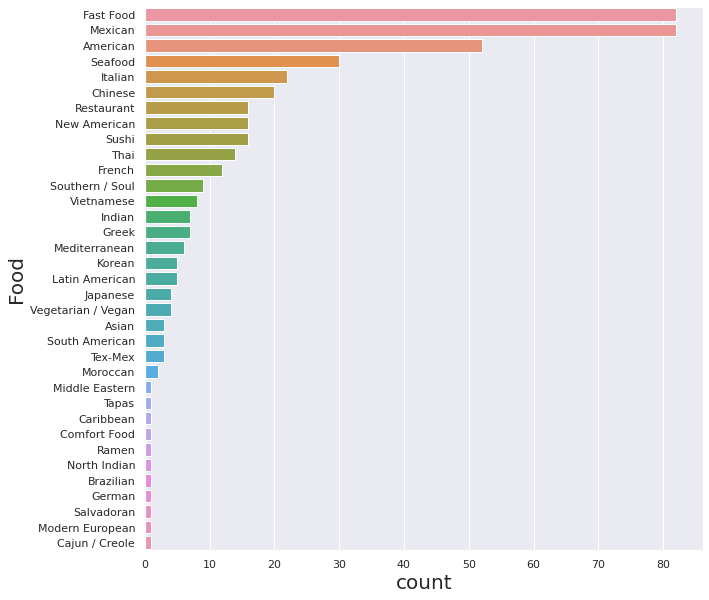

In [33]:
sns.set(rc = {"font.size":20, "axes.titlesize":20, "axes.labelsize":20, 'figure.figsize':(10,10)})
sns.countplot(y = "Food", data = restaurants_dallas, order = restaurants_dallas['Food'].value_counts().index)

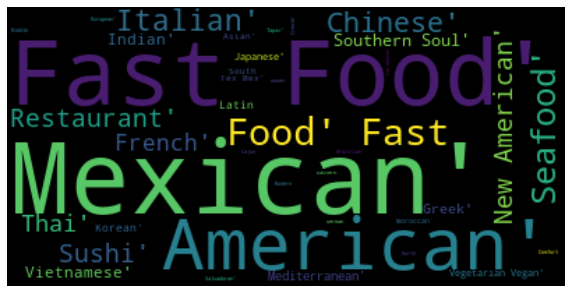

In [34]:
text = restaurants_dallas['Food'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()